In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots

# import sys
# sys.path.append("/mnt/c/Users/jonas/Desktop/phd/pytools/")
# # sys.path.append("/home/jonas/phd/pytools/")
# import npnet.tools as nptools

# gates   = ['AND','OR','XOR','NAND','NOR','XNOR']
# blue_color          = '#4477AA'
# red_color           = '#EE6677'

In [24]:
vals = np.random.randint(0,10, 50)
vals

array([9, 8, 6, 8, 8, 7, 3, 2, 8, 4, 8, 1, 5, 5, 6, 6, 2, 7, 9, 5, 3, 7,
       4, 6, 4, 6, 7, 5, 0, 4, 6, 3, 3, 9, 3, 9, 2, 1, 8, 9, 9, 4, 2, 1,
       5, 2, 5, 9, 2, 6])

In [25]:
list(np.where(vals==4)[0])

[9, 22, 24, 29, 41]

In [26]:
vals[np.where(vals==4)[0]] = 5

In [28]:
list(np.where(vals==4)[0])

[]

In [273]:
states      = {}
curr        = {}
co_curr     = {}
main        = {}
fitness     = {}

for i in [1,2]:
    try:
        states[i]       = pd.read_csv(f"mean_state_Nx=5_Ny=5_Nz=1_Ne=4zT_order_{i}.csv")
        curr[i]         = pd.read_csv(f"net_currents_Nx=5_Ny=5_Nz=1_Ne=4zT_order_{i}.csv")
        main[i]         = pd.read_csv(f"Nx=5_Ny=5_Nz=1_Ne=4zT_order_{i}.csv")
        main[i].columns = ['C1','I1','I2','O','G','Eq_Jumps','Jumps','Current','Error']
        main[i]         = main[i][['I1','I2','C1','G','Current','Error']]
        
        if i == 2:
            co_curr[i]          = pd.read_csv(f"net_cocurrents_Nx=5_Ny=5_Nz=1_Ne=4zT_order_{i}.csv")
            main['CoTunnel']    = co_curr[i].sum(axis=1).values

        main[i]['Tunnel']      = curr[i].sum(axis=1).values
        main[i]['absState']    = states[i].abs().mean(axis=1).values

        main[i] = main[i].sort_values(by='C1', ignore_index=True)
    except:
        pass

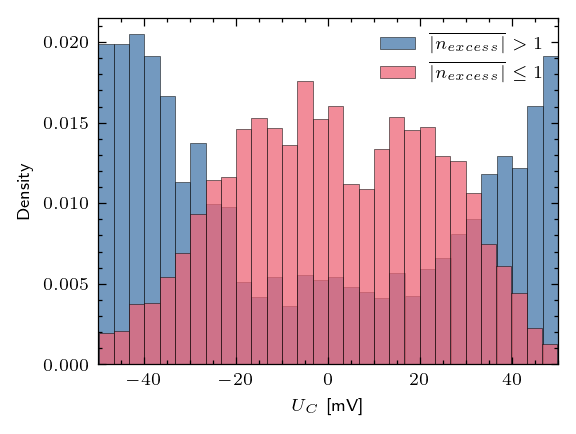

In [274]:
with plt.style.context(["science","nature","bright"]):

    fig, ax = plt.subplots(dpi=180)
    ax      = sns.histplot(main[2][main[2]['absState'] > 1]['C1'].values*1000, ax=ax, fill=True, color=blue_color, linewidth=0.2, bins=30, stat='density')
    ax      = sns.histplot(main[2][main[2]['absState'] <= 10]['C1'].values*1000, ax=ax, fill=True, color=red_color, linewidth=0.2, bins=30, stat='density')
    # ax.legend(['I\kern-0.15em P$[\Gamma_{co} < 50 \%]$','I\kern-0.15em P$[\Gamma_{co} \ge 50 \%]$'], loc='upper right')
    ax.legend(['$\\overline{|n_{excess}|} > 1$','$\\overline{|n_{excess}|} \le 1$'], loc='upper right')
    
    ax.set_xlim(-50,50)
    ax.set_xlabel("$U_C$ [mV]")

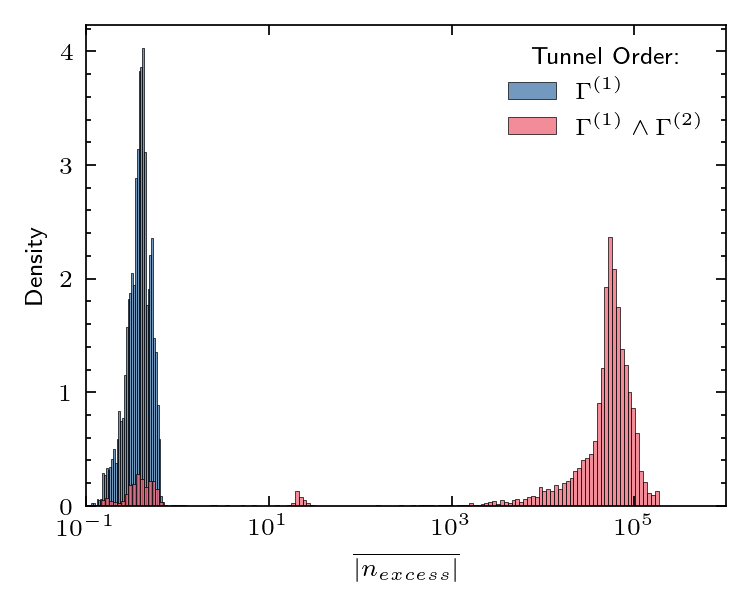

In [275]:
with plt.style.context(["science","nature"]):

    fig, ax = plt.subplots(dpi=250)
    ax      = sns.histplot(main[1]['absState'][main[1]['absState'] != 0].values, ax=ax, stat='density', log_scale=True, color=blue_color, linewidth=0.2)
    ax      = sns.histplot(main[2]['absState'][main[2]['absState'] != 0].values, ax=ax, stat='density', log_scale=True, color=red_color, linewidth=0.2)
    
    ax.legend(['$\Gamma^{(1)}$','$\Gamma^{(1)} \land \Gamma^{(2)}$'], loc='upper right', title='Tunnel Order:')
    
    ax.set_xlim(0.1,1000000)
    ax.set_xlabel("$\\overline{|n_{excess}|}$")

In [276]:
dic_f       = {}
dic_f_nc    = {}

for i in [1,2]:

    df          = pd.read_csv(f"Nx=5_Ny=5_Nz=1_Ne=4zT_order_{i}.csv")
    df.columns  = ['C1','I1','I2','O','G','Jumps_eq','Jumps','Current','Error']
    df          = df.fillna(0)
    df          = df[['I1','I2','C1','G','Jumps_eq','Jumps','Current','Error']]
    df1         = df.copy()
    df1         = df1[df1['Error'] != 0].reset_index(drop=True)
    df1         = df1.sort_values(by=['C1','G','I1','I2'], ignore_index=True)
    df1         = nptools.prepare_for_fitness_calculation(df=df1, min_current=0.0, N_c=1)

    df2         = df[~df['G'].isin(df1['G'])]
    df2         = df2.sort_values(by=['C1','G','I1','I2'], ignore_index=True)

    df1         = nptools.vary_currents_by_error(df=df1, M=20)
    df2         = nptools.vary_currents_by_error(df=df2, M=20)
    
    dff1        = nptools.fitness(df=df1, N_controls=1, error_column=None)
    dff2        = df2.drop(columns=['I1','I2','Jumps_eq','Jumps','Current'])[::4].reset_index(drop=True)
    
    for gate in gates:

        dff2[gate+' Fitness'] = -100000

    dic_f[i]      = dff1
    dic_f_nc[i]   = dff2

/home/jonas/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:137: UserWarning: AutoMinorLocator does not work with logarithmic scale
  fig.canvas.print_figure(bytes_io, **kw)


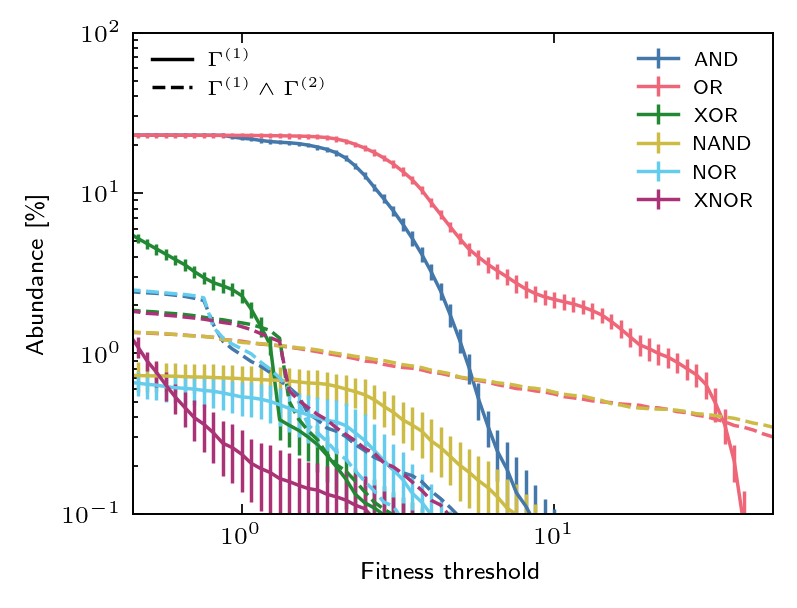

In [277]:
xrange  = np.logspace(-1,2,100)

with plt.style.context(["science","nature","bright"]):

    fig, ax = plt.subplots(dpi=250)
    
    dfa1 = pd.concat((dic_f[1],dic_f_nc[1]),ignore_index=True)
    dfa2 = pd.concat((dic_f[2],dic_f_nc[2]),ignore_index=True)
    
    for gate in ['AND','OR','XOR','NAND','NOR','XNOR']:
        
        ymean, ystd = nptools.boot_abundance(df=dfa1, xrange=xrange, gate=gate)
        p = ax.errorbar(x=xrange, y=ymean, yerr=ystd, label=gate)

        ymean, ystd = nptools.boot_abundance(df=dfa2, xrange=xrange, gate=gate)
        ax.errorbar(x=xrange, y=ymean, yerr=None, label='_nolegend_', color=p[0].get_color(), ls='--')

    ax.legend(ncol=1, fontsize='small', loc='upper right')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim(0.1,100)
    ax.set_xlim(0.45,50)
    ax.set_ylabel("Abundance [\%]")
    ax.set_xlabel("Fitness threshold")

    # Second legend
    ax2 = ax.twinx()
    for ss, sty in enumerate(['-','--']):
        if ss == 0:
            ax2.plot(np.NaN, np.NaN, ls=sty,
                    label='$\Gamma^{(1)}$', c='black')
        else:
            ax2.plot(np.NaN, np.NaN, ls=sty,
                    label='$\Gamma^{(1)} \land \Gamma^{(2)}$', c='black')
            
    ax2.get_yaxis().set_visible(False)
    ax2.legend(loc='upper left', fontsize='small')